In [103]:
# Importing Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [104]:
data=np.load("fourth_batch_multi_labels.npz")

In [105]:
X=data["X"]
y=data["yy"]



XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
yy.rename(columns={0:"user",1:"label"},inplace=True)

In [106]:
XX.head()

,user,item,rating
0,3531,0,1
1,3531,1,1
2,3531,6,1
3,3531,7,10
4,3531,9,10


In [107]:
yy.head()

,user,label
0,3240,0
1,3241,1
2,3242,0
3,3243,2
4,3244,0


In [108]:
merged_df = pd.merge(XX, yy, on='user')
merged_df.head()

,user,item,rating,label
0,3531,0,1,0
1,3531,1,1,0
2,3531,6,1,0
3,3531,7,10,0
4,3531,9,10,0


In [193]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif

def engineer_features(df_X, top_features=None, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby('user').agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std'),
        #this was the only thing i added, it was based off one of the features i added on my original one that made significant impact
        total_rating=('rating','sum'),
        
        count_dislike=('rating', lambda x: (x == -10).sum()),
        count_neutral=('rating', lambda x: (x == 0).sum()),
        count_like=('rating', lambda x: (x == 10).sum()),
        count_watched=('rating', lambda x: (x == 1).sum()),
        total_interactions=('rating', 'count')
    )

    # Ratio features
    df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
    df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
    df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
    df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']
    
    # Interaction patterns
    df_user_features['like_to_dislike_ratio'] = df_user_features['count_like'] / (df_user_features['count_dislike'] + 1)
    df_user_features['rating_variance'] = df_X.groupby('user')['rating'].var()
    
    # Distribution features
    df_user_features['rating_skew'] = df_X.groupby('user')['rating'].apply(lambda x: skew(x))
    df_user_features['rating_kurtosis'] = df_X.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
    # User behavior patterns
    df_user_features['rating_range'] = df_X.groupby('user')['rating'].apply(lambda x: x.max() - x.min())
    df_user_features['unique_items_ratio'] = df_X.groupby('user')['item'].nunique() / df_user_features['total_interactions']
    
    # Item popularity metrics
    item_popularity = df_X.groupby('item')['rating'].agg(['mean', 'count'])
    item_popularity['popularity_score'] = item_popularity['mean'] * np.log1p(item_popularity['count'])
    
    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(df_X, item_popularity['popularity_score'], left_on='item', right_index=True)
    
    # User-item interaction features
    df_user_features['mean_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].mean()
    df_user_features['std_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].std()

        
    # If labels are provided, merge with df_y
    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on='user')

        # Feature selection using mutual information
        X = df_merged.drop(columns=['user', 'label'])
        y = df_merged['label']
        mi_scores = mutual_info_classif(X, y)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        
        # Select top 15 features
        top_features = mi_scores.nlargest(21).index.tolist()

        # Return the merged dataframe with selected features, label, and top features
        return df_merged[['user'] + top_features + ['label']], top_features

    # If no labels (unseen data), just select the top features
    else:
        # Ensure top_features is provided
        if top_features is None:
            raise ValueError("top_features must be provided for unseen data")
        
        # Return the dataframe with only the selected top features
        df_merged = df_user_features.reset_index()
        return df_merged[['user'] + top_features]

# Use the function
df_merged, top_features = engineer_features(XX, df_y=yy)

In [194]:
X_features = df_merged.drop(columns=['user', 'label'])
y_labels = df_merged['label']
print(X_features)
print(y_labels)

     rating_variance  std_rating  rating_kurtosis  dislike_ratio  \
0          40.600830    6.371878        -0.521521       0.198113   
1          51.176832    7.153798        -1.091737       0.330935   
2          46.306210    6.804867        -0.891638       0.284211   
3          53.249594    7.297232        -0.986740       0.202532   
4          22.658824    4.760129        -1.901267       0.000000   
..               ...         ...              ...            ...   
545        20.269231    4.502136        -1.309731       0.000000   
546        41.337477    6.429423        -0.781821       0.311512   
547        24.622705    4.962127        -0.956307       0.012931   
548        47.045752    6.858991        -0.429193       0.111111   
549        51.058290    7.145508        -0.953996       0.206522   

     like_to_dislike_ratio  total_rating  like_ratio  neutral_ratio  \
0                 1.023529           184    0.205189       0.233491   
1                 0.553191          -158 

In [195]:
from sklearn.model_selection import train_test_split


In [207]:
import tensorflow as tf
from tensorflow import keras

# Sample CNN model for reshaped input data
model_cnn = keras.Sequential([
    keras.layers.Conv2D(32, (1,1), activation='relu', input_shape=(21, 1, 1)),  # Input shape: (15, 1, 1)
    keras.layers.MaxPooling2D((1, 1)),  # Adjust pooling size as needed
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes for classification
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\Garion\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [209]:
X = X_features.to_numpy()

X_reshaped = X.reshape(550, 21, 1, 1)
print(X_reshaped.shape)
model_cnn.fit(X_reshaped, y_labels, epochs=50, validation_split=0.2)


(550, 21, 1, 1)
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8569 - loss: 1.2756 - val_accuracy: 0.4455 - val_loss: 1.5978
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8075 - loss: 0.9563 - val_accuracy: 0.8727 - val_loss: 0.2965
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9017 - loss: 0.3478 - val_accuracy: 0.9545 - val_loss: 0.1570
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9219 - loss: 0.3016 - val_accuracy: 0.9636 - val_loss: 0.1654
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9039 - loss: 0.3825 - val_accuracy: 0.9455 - val_loss: 0.2848
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9067 - loss: 0.5101 - val_accuracy: 0.9636 - val_loss: 0.1432
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9050 - loss: 0.4009 - val_accuracy: 0.9545 - val_loss: 0.2469
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9290 - loss: 0.3501 - val_accuracy: 0

In [212]:
model_cnn.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 21, 1, 32)      │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 21, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 672)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │        43,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,995 (507.80 KB)

 Trainable params: 43,331 (169.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 86,664 (338.54 KB)

In [214]:
# Assuming the model has already been trained

# Step 1: Make predictions
predictions = model_cnn.predict(X_reshaped)

# Step 2: Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Display the predicted labels
print("Predicted labels:", predicted_labels)

# Optional: Compare with true labels
print("True labels:", y_labels)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicted labels: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 

In [216]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_labels, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, f1-score
report = classification_report(y_labels, predicted_labels)
print("Classification Report:\n", report)


Confusion Matrix:
 [[497   2   1]
 [ 22   1   2]
 [  6   1  18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       500
           1       0.25      0.04      0.07        25
           2       0.86      0.72      0.78        25

    accuracy                           0.94       550
   macro avg       0.68      0.58      0.61       550
weighted avg       0.91      0.94      0.92       550



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


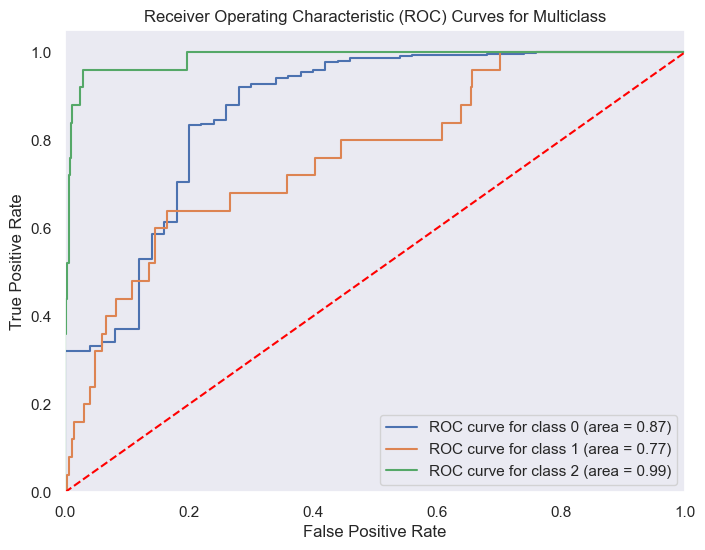

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming your model's predictions and true labels
# Get predicted probabilities
predicted_probabilities = model_cnn.predict(X_reshaped)

# Binarize the true labels for multiclass ROC calculation
# Assuming y_labels are the true class labels (0, 1, 2)
n_classes = 3  # Number of classes
y_true = label_binarize(y_labels, classes=[0, 1, 2])  # Binarize the labels

# Step 1: Calculate ROC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 2: Plot ROC curves
plt.figure(figsize=(8, 6))

# Plotting each class's ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plot the random chance line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.show()
